In [17]:
# Imports & Config
import os, re, math, json, time
from pathlib import Path
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Paths (edit if needed)
GROUPED_DIR = Path(r"D:\Courses\thesis\data\turning_keypoints_grouped")   # grouped by (PD_or_C / angle / type_of_turn)
MODEL_DIR   = Path(r"D:\Courses\thesis\data\models_turning")              # per-type model checkpoints
SYN_DIR     = Path(r"D:\Courses\thesis\data\synthetic_turning")           # generated CSVs
MODEL_DIR.mkdir(parents=True, exist_ok=True)
SYN_DIR.mkdir(parents=True, exist_ok=True)

# Data/Model params
NUM_KPT = 17
INPUT_DIM = NUM_KPT * 2
WINDOW = 10
BATCH_SIZE = 64
EPOCHS = 25
LR = 1e-3
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
print("Device:", DEVICE)


Device: cuda


In [18]:
# Basic helpers: list groups, parse subject id
def list_groups(grouped_dir: Path):
    """Return list of (pd_or_c, angle, turn_type, path, n_files)."""
    triples = []
    for pdc_dir in sorted([p for p in grouped_dir.iterdir() if p.is_dir()]):
        for angle_dir in sorted([p for p in pdc_dir.iterdir() if p.is_dir()]):
            for ttype_dir in sorted([p for p in angle_dir.iterdir() if p.is_dir()]):
                n = len(list(ttype_dir.glob("*.csv")))
                if n > 0:
                    triples.append((pdc_dir.name, angle_dir.name, ttype_dir.name, ttype_dir, n))
    return triples

def parse_subject_id_from_filename(name: str):
    # e.g., Pt204_C_n_350.csv -> subject 204
    m = re.match(r"Pt(\d+)_", name)
    if m:
        try:
            return int(m.group(1))
        except:
            return None
    return None


In [20]:
# Robust XY column selection (handles x/y/conf variants & reordering)
def _select_xy_columns(df, input_dim=34):
    """
    Try to pick 34 XY columns in correct order.
    1) Named x1,y1,...,x17,y17
    2) If numeric cols == 51 (17 * [x,y,conf]) -> take first two of each triple
    3) If numeric cols is multiple of 3 -> take first two of each triple
    4) Else take first 34 numeric cols
    """
    num_df = df.apply(pd.to_numeric, errors='coerce')

    # 1) Named xN/yN
    xs, ys = [], []
    for c in num_df.columns:
        m = re.fullmatch(r"[xX](\d+)", str(c).strip())
        if m: xs.append((int(m.group(1)), c))
        m = re.fullmatch(r"[yY](\d+)", str(c).strip())
        if m: ys.append((int(m.group(1)), c))
    if xs and ys:
        xs = sorted(xs, key=lambda t: t[0])[:17]
        ys = sorted(ys, key=lambda t: t[0])[:17]
        if len(xs) == 17 and len(ys) == 17:
            cols = []
            for k in range(17):
                cols += [xs[k][1], ys[k][1]]
            return cols

    # 2) Triple pattern by count
    num_cols = [c for c in num_df.columns if num_df[c].dtype.kind in "fcui"]
    n = len(num_cols)
    if n == 51:  # 17 * 3
        cols = []
        for i in range(17):
            cols += [num_cols[3*i + 0], num_cols[3*i + 1]]
        return cols

    # 3) Generic triple case
    if n % 3 == 0 and n >= 51:
        triplets = n // 3
        keep = min(triplets, 17)
        cols = []
        for i in range(keep):
            cols += [num_cols[3*i + 0], num_cols[3*i + 1]]
        while len(cols) < input_dim:
            cols.append(num_cols[len(cols)])
        return cols[:input_dim]

    # 4) Fallback: first 34 numeric
    if n >= input_dim:
        return num_cols[:input_dim]

    return None


In [ ]:
# Read one CSV & load a group with a canonical XY schema
def read_keypoints_csv(path: Path, input_dim=34):
    df = pd.read_csv(path, low_memory=False)
    cols = _select_xy_columns(df, input_dim=input_dim)
    if cols is None:
        return None
    arr = df[cols].apply(pd.to_numeric, errors='coerce').dropna().to_numpy(dtype=np.float32)
    if arr.shape[0] < WINDOW + 2 or arr.shape[1] != input_dim:
        return None
    return arr, cols

def load_group_sequences(group_path: Path, input_dim=34):
    files = sorted(group_path.glob("*.csv"))
    tmp = []
    for f in files:
        out = read_keypoints_csv(f, input_dim=input_dim)
        if out is None:
            continue
        arr, cols = out
        tmp.append((f, arr, cols))

    if not tmp:
        return [], [], [], []

    # pick most frequent schema as canonical
    from collections import Counter
    key = lambda cols: "|".join(cols)
    modes = Counter(key(cols) for _,_,cols in tmp).most_common()
    canonical = modes[0][0].split("|")

    file_list, seqs, headers, subjs = [], [], [], []
    for f, arr, cols in tmp:
        if cols != canonical:
            df = pd.read_csv(f, low_memory=False)
            if all(c in df.columns for c in canonical):
                A = df[canonical].apply(pd.to_numeric, errors='coerce').dropna().to_numpy(dtype=np.float32)
                if A.shape[0] >= WINDOW + 2 and A.shape[1] == input_dim:
                    arr = A
                    cols = canonical
                else:
                    continue
            else:
                continue
        file_list.append(f.name)
        seqs.append(arr)
        headers.append(cols)
        subjs.append(parse_subject_id_from_filename(f.name))

    return file_list, seqs, headers, subjs


In [21]:
# Split subject-aware, windows count, scaler util
def split_subject_aware(file_list, seqs, subjs, test_size=0.15, seed=42):
    """Safer split; if val would be empty, do train-only."""
    man = pd.DataFrame({"idx": range(len(file_list)), "subj": subjs})
    known = man[man["subj"].notna()]
    unknown = man[man["subj"].isna()]

    train_idx, val_idx = [], []

    if len(known["subj"].unique()) >= 2:
        tr_subj, va_subj = train_test_split(sorted(known["subj"].unique()),
                                            test_size=test_size, random_state=seed, shuffle=True)
        train_idx += known[known["subj"].isin(tr_subj)]["idx"].tolist()
        val_idx   += known[known["subj"].isin(va_subj)]["idx"].tolist()
    else:
        if len(known) >= 2:
            tr, va = train_test_split(known["idx"].tolist(),
                                      test_size=max(1/len(known), test_size),
                                      random_state=seed, shuffle=True)
            train_idx += tr; val_idx += va

    if len(unknown) >= 2:
        tr, va = train_test_split(unknown["idx"].tolist(),
                                  test_size=max(1/len(unknown), test_size),
                                  random_state=seed, shuffle=True)
        train_idx += tr; val_idx += va
    else:
        train_idx += unknown["idx"].tolist()

    if len(val_idx) == 0:
        train_idx = man["idx"].tolist()
        val_idx = []

    train_seqs = [seqs[i] for i in train_idx]
    val_seqs   = [seqs[i] for i in val_idx]
    return train_seqs, val_seqs, train_idx, val_idx

def make_windows_count(seqs, win):
    return sum(max(0, len(s)-win) for s in seqs)

def scaler_from_params(mean, scale):
    sc = StandardScaler()
    sc.mean_ = np.array(mean, dtype=np.float64)
    sc.scale_ = np.array(scale, dtype=np.float64)
    sc.var_ = sc.scale_**2
    sc.n_features_in_ = len(sc.mean_)
    return sc


In [22]:
# Transformer-VAE (batch_first=True) and loss
class PositionalEncodingBF(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1,L,D)
    def forward(self, x):  # x: (B,T,D)
        return x + self.pe[:, :x.size(1), :]

class TransformerVAE_BF(nn.Module):
    def __init__(self, input_dim, win=WINDOW, d_model=96, nhead=6, num_layers=3, latent_dim=48):
        super().__init__()
        self.win = win
        self.input_linear = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncodingBF(d_model, max_len=win)
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.fc_mu = nn.Linear(d_model * win, latent_dim)
        self.fc_logvar = nn.Linear(d_model * win, latent_dim)
        self.fc_latent = nn.Linear(latent_dim, d_model * win)
        dec_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.decoder = nn.TransformerDecoder(dec_layer, num_layers=num_layers)
        self.output_linear = nn.Linear(d_model, input_dim)
    def encode(self, x):
        h = self.input_linear(x)
        h = self.pos_enc(h)
        out = self.encoder(h)                # (B,T,D)
        flat = out.reshape(out.size(0), -1)
        return self.fc_mu(flat), self.fc_logvar(flat)
    def reparameterize(self, mu, logvar, temperature=1.3):
        std = torch.exp(0.5 * logvar) * temperature
        eps = torch.randn_like(std)
        return mu + eps * std
    def decode(self, z):
        x = self.fc_latent(z).view(z.size(0), self.win, -1)
        tgt = self.pos_enc(x)
        memory = torch.zeros(z.size(0), self.win, tgt.size(2), device=z.device)  # (B,T,D)
        out = self.decoder(tgt, memory)
        return self.output_linear(out)
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

def simple_enhanced_loss(recon_x, x, mu, logvar):
    mse = nn.MSELoss()(recon_x, x)
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    vel_orig = torch.diff(x, dim=1)
    vel_recon = torch.diff(recon_x, dim=1)
    vel_loss = nn.MSELoss()(vel_recon, vel_orig)
    return mse + 0.1*kld + 0.15*vel_loss


In [24]:
# Train one group and save checkpoint
class _WindowDataset(Dataset):
    def __init__(self, seqs, scaler, win):
        xs = []
        for s in seqs:
            s2 = scaler.transform(s)
            for i in range(win, len(s2)):
                xs.append(s2[i-win:i])
        self.samples = np.asarray(xs, np.float32)
    def __len__(self): return len(self.samples)
    def __getitem__(self, i): return torch.tensor(self.samples[i], dtype=torch.float32)

def train_one_group(triple, group_path: Path):
    file_list, seqs, headers, subjs = load_group_sequences(group_path, INPUT_DIM)
    if len(seqs) == 0:
        print(f"  [SKIP empty] {triple}")
        return None

    train_seqs, val_seqs, train_idx, val_idx = split_subject_aware(
        file_list, seqs, subjs, test_size=0.15, seed=SEED
    )

    if make_windows_count(train_seqs, WINDOW) < 64:
        print(f"  [SKIP small] {triple} — not enough windows")
        return None

    scaler = StandardScaler().fit(np.concatenate(train_seqs, axis=0))

    train_loader = DataLoader(_WindowDataset(train_seqs, scaler, WINDOW),
                              batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    val_loader = DataLoader(_WindowDataset(val_seqs, scaler, WINDOW),
                            batch_size=BATCH_SIZE, shuffle=False, drop_last=False) if len(val_seqs)>0 else None

    model = TransformerVAE_BF(INPUT_DIM, win=WINDOW).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR)

    best_val = math.inf
    best_state = None

    for epoch in range(1, EPOCHS+1):
        model.train(); total = 0.0
        for b in train_loader:
            b = b.to(DEVICE)
            opt.zero_grad()
            recon, mu, logvar = model(b)
            loss = simple_enhanced_loss(recon, b, mu, logvar)
            loss.backward()
            opt.step()
            total += loss.item()

        if (epoch % 5 == 0) or epoch == 1:
            if val_loader is not None and len(val_loader) > 0:
                model.eval(); vtot = 0.0
                with torch.no_grad():
                    for vb in val_loader:
                        vb = vb.to(DEVICE)
                        r, m, l = model(vb)
                        vtot += simple_enhanced_loss(r, vb, m, l).item()
                vloss = vtot / len(val_loader)
            else:
                vloss = float('nan')

            print(f"  Epoch {epoch:02d}/{EPOCHS} — train {total/len(train_loader):.5f} val {vloss:.5f}")
            if not math.isnan(vloss) and vloss < best_val:
                best_val = vloss
                best_state = model.state_dict()

    if best_state is not None:
        model.load_state_dict(best_state)

    # canonical header (most frequent)
    header_series = pd.Series(["|".join(h) for h in headers if h])
    header_cols = header_series.mode().iloc[0].split("|") if not header_series.empty \
                  else [f"{ax}{i}" for i in range(1, NUM_KPT+1) for ax in ("x","y")]

    tag = "__".join(triple)
    ckpt = MODEL_DIR / f"TVAE_{tag}.pt"
    torch.save({
        "model_state": model.state_dict(),
        "scaler_mean": scaler.mean_,
        "scaler_scale": scaler.scale_,
        "header_cols": header_cols,
        "meta": {
            "group": triple,
            "input_dim": INPUT_DIM,
            "window": WINDOW,
            "epochs": EPOCHS,
            "best_val": float(best_val) if not math.isnan(best_val) else None,
            "date": time.strftime("%Y-%m-%d %H:%M:%S"),
        }
    }, ckpt)
    return ckpt


In [25]:
# Train all groups and save a manifest
groups = list_groups(GROUPED_DIR)
print(f"Discovered {len(groups)} groups.")

manifest_rows = []
for pd_or_c, angle, ttype, path, n_files in groups:
    triple = (pd_or_c, angle, ttype)
    tag = "__".join(triple)
    ckpt_path = MODEL_DIR / f"TVAE_{tag}.pt"
    if ckpt_path.exists():
        print(f"[SKIP existing] {triple}")
        saved = True
        ckpt = ckpt_path
    else:
        print(f"[TRAIN] {triple}  ({n_files} files)")
        try:
            ckpt = train_one_group(triple, path)
            saved = ckpt is not None
        except Exception as e:
            print(f"  ERROR training {triple}: {e}")
            ckpt = None
            saved = False

    manifest_rows.append({
        "PD_or_C": pd_or_c,
        "turning_angle": angle,
        "type_of_turn": ttype,
        "n_files": n_files,
        "model_saved": saved,
        "model_path": str(ckpt) if ckpt else None,
    })

manifest = pd.DataFrame(manifest_rows)
manifest_csv = MODEL_DIR / "_models_manifest.csv"
manifest.to_csv(manifest_csv, index=False)
print("\nSaved model manifest:", manifest_csv)
print(manifest.head(20))


Discovered 21 groups.
[TRAIN] ('C', '135_degrees', '-')  (1 files)
  [SKIP small] ('C', '135_degrees', '-') — not enough windows
[SKIP existing] ('C', '135_degrees', 'pivot_turn')
[TRAIN] ('C', '135_degrees', 'step_turn')  (3 files)
  Epoch 01/25 — train 1.38920 val 0.89666
  Epoch 05/25 — train 0.97887 val 0.52329
  Epoch 10/25 — train 0.33975 val 0.71220
  Epoch 15/25 — train 0.20499 val 0.79075
  Epoch 20/25 — train 0.29086 val 0.86455
  Epoch 25/25 — train 0.19703 val 0.73511
[SKIP existing] ('C', '180_degrees', 'pivot_turn')
[SKIP existing] ('C', '180_degrees', 'step_turn')
[SKIP existing] ('C', '225_degrees', 'pivot_turn')
[TRAIN] ('C', '360_degrees', 'pivot_turn')  (1 files)
  Epoch 01/25 — train 1.37877 val nan
  Epoch 05/25 — train 0.99891 val nan
  Epoch 10/25 — train 0.83192 val nan
  Epoch 15/25 — train 0.75520 val nan
  Epoch 20/25 — train 0.67934 val nan
  Epoch 25/25 — train 0.53271 val nan
[SKIP existing] ('C', '90_degrees', '-')
[SKIP existing] ('C', '90_degrees', 'piv

In [29]:
# Load a saved model & generation helpers
# PATCH: robust loader for PyTorch 2.6+ (weights_only default)
import pickle
from pathlib import Path

def load_model_for_group(triple):
    tag = "__".join(triple)
    ckpt = MODEL_DIR / f"TVAE_{tag}.pt"
    if not ckpt.exists():
        raise FileNotFoundError(f"No checkpoint for {triple}: {ckpt}")

    # Try default (older PyTorch), then fall back to weights_only=False for 2.6+
    try:
        data = torch.load(ckpt, map_location=DEVICE)
    except pickle.UnpicklingError:
        # New default blocks numpy types; allow full pickle
        data = torch.load(ckpt, map_location=DEVICE, weights_only=False)
    except Exception as e:
        # Final fallback: allowlist the numpy reconstruct if needed
        try:
            from torch.serialization import add_safe_globals
            import numpy as np
            add_safe_globals([np.core.multiarray._reconstruct])
            data = torch.load(ckpt, map_location=DEVICE)
        except Exception:
            raise e

    model = TransformerVAE_BF(INPUT_DIM, win=data["meta"]["window"]).to(DEVICE)
    model.load_state_dict(data["model_state"])
    model.eval()

    scaler = scaler_from_params(data["scaler_mean"], data["scaler_scale"])
    header_cols = data.get("header_cols", [f"{ax}{i}" for i in range(1, NUM_KPT+1) for ax in ("x","y")])
    return model, scaler, header_cols


def generate_sequence(model, scaler, target_len, seed_seq=None, n_variants=1):
    """
    Generate a continuous sequence:
    - If seed_seq provided (NxF), bootstrap with first WINDOW frames.
    - Else seedless: random latent for initial window, then roll out.
    """
    variants = []
    with torch.no_grad():
        for _ in range(n_variants):
            if seed_seq is not None and len(seed_seq) >= WINDOW:
                seed_scaled = scaler.transform(seed_seq[:WINDOW])
                seed_tensor = torch.tensor(seed_scaled[None], dtype=torch.float32, device=DEVICE)
                mu, logvar = model.encode(seed_tensor)
                current_window = [scaler.inverse_transform(seed_scaled)[i] for i in range(WINDOW)]
            else:
                latent_dim = model.fc_latent.in_features
                z0 = torch.randn(1, latent_dim, device=DEVICE)
                synth_scaled = model.decode(z0)[0].detach().cpu().numpy()  # (T,F)
                current_window = scaler.inverse_transform(synth_scaled).tolist()
                current_window = current_window[-WINDOW:]
                window_scaled = scaler.transform(np.array(current_window))
                seed_tensor = torch.tensor(window_scaled[None], dtype=torch.float32, device=DEVICE)
                mu, logvar = model.encode(seed_tensor)

            generated = []
            for _t in range(target_len):
                z = model.reparameterize(mu, logvar)
                synth_scaled = model.decode(z)[0].detach().cpu().numpy()
                frame = scaler.inverse_transform(synth_scaled[-1][None])[0]
                generated.append(frame)

                current_window.append(frame)
                if len(current_window) > WINDOW:
                    current_window = current_window[-WINDOW:]
                window_scaled = scaler.transform(np.array(current_window))
                seed_tensor = torch.tensor(window_scaled[None], dtype=torch.float32, device=DEVICE)
                mu, logvar = model.encode(seed_tensor)

            variants.append(np.array(generated))
    return variants


In [30]:
# Example usage: change to any triple that was trained (model_saved=True in manifest)
CHOSEN_GROUP = ('PD', '90_degrees', 'pivot_turn')   # <-- edit to a trained triple

try:
    model, scaler, header_cols = load_model_for_group(CHOSEN_GROUP)
    group_path = GROUPED_DIR / CHOSEN_GROUP[0] / CHOSEN_GROUP[1] / CHOSEN_GROUP[2]
    some_file = next(group_path.glob("*.csv"))
    seed_arr, _ = read_keypoints_csv(some_file, INPUT_DIM)

    target_len = len(seed_arr)

    # Seeded generation
    variants = generate_sequence(model, scaler, target_len=target_len, seed_seq=seed_arr, n_variants=1)
    synth = variants[0]
    out_csv = SYN_DIR / f"synthetic_{CHOSEN_GROUP[0]}__{CHOSEN_GROUP[1]}__{CHOSEN_GROUP[2]}_seeded.csv"
    pd.DataFrame(synth, columns=header_cols).to_csv(out_csv, index=False, float_format="%.1f")
    print("Saved (seeded):", out_csv)

    # Seedless generation
    variants2 = generate_sequence(model, scaler, target_len=target_len, seed_seq=None, n_variants=1)
    synth2 = variants2[0]
    out_csv2 = SYN_DIR / f"synthetic_{CHOSEN_GROUP[0]}__{CHOSEN_GROUP[1]}__{CHOSEN_GROUP[2]}_seedless.csv"
    pd.DataFrame(synth2, columns=header_cols).to_csv(out_csv2, index=False, float_format="%.1f")
    print("Saved (seedless):", out_csv2)

except StopIteration:
    print("No CSV found in the chosen group's folder. Pick another CHOSEN_GROUP.")
except FileNotFoundError as e:
    print(e)


Saved (seeded): D:\Courses\thesis\data\synthetic_turning\synthetic_PD__90_degrees__pivot_turn_seeded.csv
Saved (seedless): D:\Courses\thesis\data\synthetic_turning\synthetic_PD__90_degrees__pivot_turn_seedless.csv


In [38]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----- point this to where you saved the generated file -----
SYN_DIR = Path(r"D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\turning_2D3D_skeletons_coarsened\Turning_coarsen_CSV\Pt204_C_n_440")  # or your output_dir
keypoints_csv_path = SYN_DIR / "input_2D/keypoints.csv"
# SYN_DIR = Path(r"D:\Courses\thesis\data\synthetic_turning")  # or your output_dir
# keypoints_csv_path = SYN_DIR / "synthetic_PD__90_degrees__pivot_turn_seedless.csv"
# output_dir = Path(r'D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\turning_2D3D_skeletons_coarsened\Turning_coarsen_CSV\Pt204_C_n_440')
if not keypoints_csv_path.exists():
    raise FileNotFoundError(f"File not found: {keypoints_csv_path}")

dimension = 2
number_of_joints = 17
expected_cols = number_of_joints * dimension

# Load with pandas (handles headers); coerce everything to numeric
df = pd.read_csv(keypoints_csv_path)

# If there are extra columns, keep the first 34; if fewer, error
if df.shape[1] < expected_cols:
    # try again assuming there's no header row
    df = pd.read_csv(keypoints_csv_path, header=None)
if df.shape[1] < expected_cols:
    raise ValueError(f"Expected at least {expected_cols} numeric columns, got {df.shape[1]}.")

# Keep exactly the first 34 columns and coerce to numeric
df = df.iloc[:, :expected_cols].apply(pd.to_numeric, errors="coerce")
df = df.dropna(axis=0, how="any")  # drop any rows with bad entries (e.g., 'e+02.1' glitches)

arr = df.to_numpy(dtype=np.float32)             # shape: (T, 34)
T = arr.shape[0]
keypoints = arr.reshape(T, number_of_joints, dimension)  # (T, 17, 2)

print(f"Loaded frames: {T}, array shape: {arr.shape}, keypoints shape: {keypoints.shape}")  # (T,17,2)


Loaded frames: 74, array shape: (74, 34), keypoints shape: (74, 17, 2)


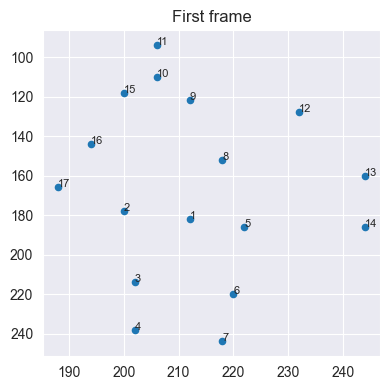

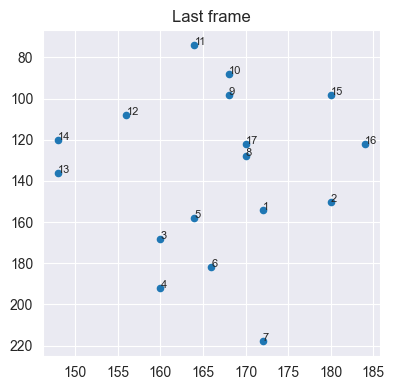

In [39]:
def plot_skeleton(xy, title=""):
    # xy: (17,2) -> simple scatter; connect a few plausible limbs if you want
    plt.figure(figsize=(4,4))
    plt.scatter(xy[:,0], xy[:,1], s=20)
    for i in range(xy.shape[0]):
        plt.text(xy[i,0], xy[i,1], str(i+1), fontsize=8)
    plt.gca().invert_yaxis()   # image coords usually have y down
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_skeleton(keypoints[0],  "First frame")
plot_skeleton(keypoints[-1], "Last frame")


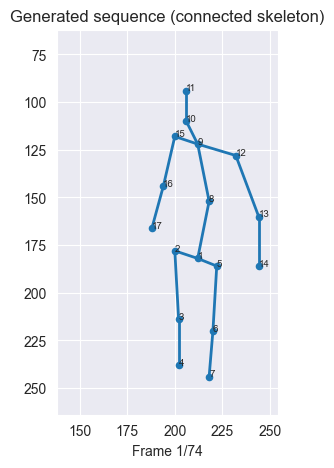

In [40]:
# Connected-skeleton animation for generated keypoints
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.collections import LineCollection

# render animations inline as JS
rc('animation', html='jshtml')

# your connections (0–16 indexing)
connections = [
    [0, 1], [1, 2], [2, 3],
    [0, 4], [4, 5], [5, 6],
    [0, 7], [7, 8], [8, 9], [9, 10],
    [8, 11], [11, 12], [12, 13],
    [8, 14], [14, 15], [15, 16],
]

T = keypoints.shape[0]
assert keypoints.shape == (T, 17, 2)

# fixed axes so the view doesn't jump
xmin, xmax = keypoints[:,:,0].min(), keypoints[:,:,0].max()
ymin, ymax = keypoints[:,:,1].min(), keypoints[:,:,1].max()

fig, ax = plt.subplots(figsize=(5,5))
ax.set_title("Generated sequence (connected skeleton)")
ax.set_xlim(xmin-10, xmax+10)
ax.set_ylim(ymin-10, ymax+10)
ax.set_aspect('equal', adjustable='box')
ax.invert_yaxis()  # image coords

# draw first frame
pts0 = keypoints[0]
sc = ax.scatter(pts0[:,0], pts0[:,1], s=20)

# create a LineCollection for bones
segs0 = [pts0[[i,j], :] for (i,j) in connections]
lc = LineCollection(segs0, linewidths=2)
ax.add_collection(lc)

# (optional) tiny joint labels
labels = [ax.text(pts0[i,0], pts0[i,1], str(i+1), fontsize=7) for i in range(17)]

def update(t):
    pts = keypoints[t]
    sc.set_offsets(pts)
    # update bone segments
    segs = [pts[[i,j], :] for (i,j) in connections]
    lc.set_segments(segs)
    # update labels
    for i, txt in enumerate(labels):
        txt.set_position((pts[i,0], pts[i,1]))
    ax.set_xlabel(f"Frame {t+1}/{T}")
    return [sc, lc, *labels]

ani = animation.FuncAnimation(fig, update, frames=T, interval=50, blit=False)
ani  # displays inline in Jupyter
